<a href="https://colab.research.google.com/github/TahmouresAmirt/Concrete-Crack-Detection/blob/main/Concrete_Crack_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Concrete Crack Detection**:

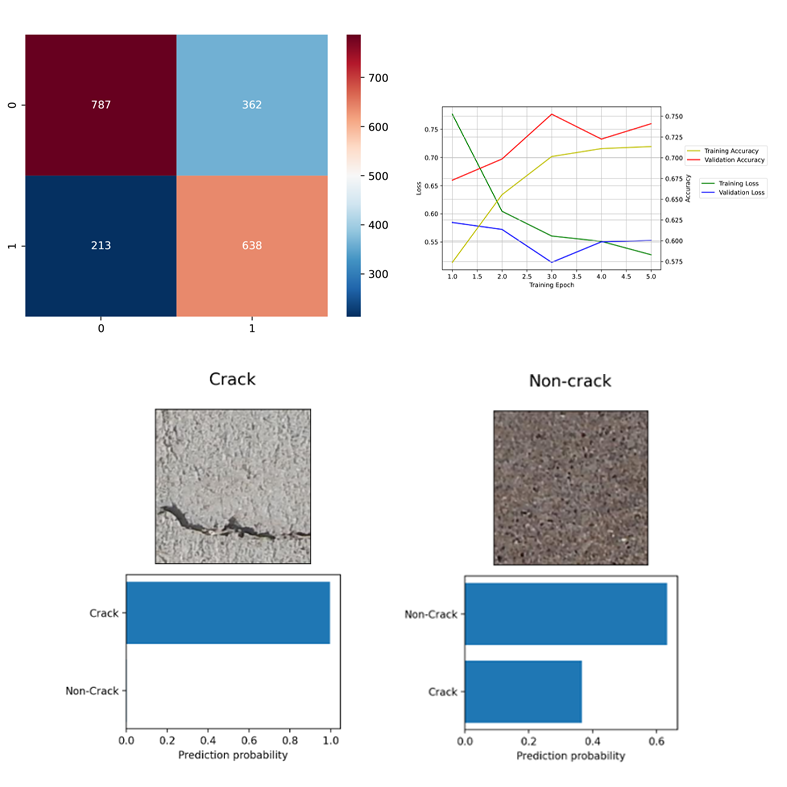

This Jupyter Notebook aims to detect cracks in concrete using image processing techniques with the help of transfer learning. The approach involves leveraging pre-trained models to train a neural network that can accurately classify concrete images into two defined classes: "Crack" and "Non-Crack."

Users are encouraged to utilize their concrete images containing the two defined classes for training the network, enabling the model to learn and differentiate between concrete surfaces with and without cracks.
If users do not have the necessary concrete images, they can use the following link to download the required dataset for training the neural network.

Dataset:

[A concrete crack image dataset for machine learning applications](https://digitalcommons.usu.edu/context/all_datasets/article/1047/type/native/viewcontent)

Description:

[More about the dataset (Source and Description)](https://digitalcommons.usu.edu/all_datasets/48/)

# **Stage 1:**

In [ ]:
# Imports
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt
import math
import time
import copy
import numpy as np
from PIL import Image
import os
import sys

# Import Pytorch modules
import torch
from torch import optim, nn
import torch.nn.functional as F
from torchvision import datasets, transforms, models
!pwd # Preferred to be in content

/content


#**Stage 2:**

After importing the required libraries, the data must be prepared for the preprocessing stage.

**Please follow the instructions:**


*  Please split the data set into a folder with 3 sub-folders with the names train, test and valid.  
*  Each train, test and valid folder contains two class folders with names 1 for Crack and 2 for Non-Crack  
*  Zip the main folder (*.rar).
* Upload the zip file on colab.
* Be sure that the file is in the content folder (if it is not, move the file to the content)(It is recommended).
* Run the following block (Pay attention to the file name).



In [ ]:
!pip install unrar
!pip install pyunpack
!pip install patool
from pyunpack import Archive
Archive('/content/Twoclass.rar').extractall('/content/') # The file name must be checked and changed if necessary.

# **Stage 3:**
In this stage, the preprocessing procedure occurs on data. For the training, we apply the following transformations:
- Random rotation
- Random resized cropping
- Random horizontal flipping
- Normalization
- Resizing to 224x224 pixel images

The pre-trained networks were trained on the ImageNet dataset where each color channel was normalized separately. All data has normalized the means and standard deviations of the images to what the network expects.
- Means: `[0.485, 0.456, 0.406]`
- Standard Deviations: `[0.229, 0.224, 0.225]`
- Please just run the following blocks (Pay attention to the  block, which is required to mount to your Google Drive, so please give the permission)
- The mapping process must be done (Pay attention to the last block in this stage).


In [ ]:
# General setup
###############

# Training phases
phases = ['train', 'valid', 'test']

# Training Images Details
IMG_SIZE = 224  # Size of images used for training
IMG_MEAN = [0.485, 0.456, 0.406]
IMG_SDEV = [0.229, 0.224, 0.225]

# Define data locations
data_dir = {n: '/content/Twoclass/' + n for n in phases}

In [ ]:
# Define transforms for the training, validation, and testing sets
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomRotation(30),
        transforms.RandomResizedCrop(IMG_SIZE),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.ToTensor(),
        transforms.Normalize(IMG_MEAN, IMG_SDEV)
    ]),
    'valid': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(IMG_SIZE),
        transforms.ToTensor(),
        transforms.Normalize(IMG_MEAN, IMG_SDEV)
    ]),
    'test': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(IMG_SIZE),
        transforms.ToTensor(),
        transforms.Normalize(IMG_MEAN, IMG_SDEV)
    ])
}

In [ ]:
# Load the datasets
image_datasets = {n: datasets.ImageFolder(data_dir[n], transform=data_transforms[n]) for n in phases}

# Define the PyTorch dataloaders
dataloaders = {n: torch.utils.data.DataLoader(image_datasets[n], batch_size=64, shuffle=True) for n in phases}

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


**Attention:**

Mapping from category label to category name is found in the `cat_to_name.json` file.

Upload the `cat_to_name.json`  in this folder (The file could be accessible in GitHub repository).

In [ ]:
import json

with open('cat_to_name.json', 'r') as f:
    cat_to_name = json.load(f)

print(len(list(cat_to_name.keys()))) # See the number of the classes

# Stage 4:
**Build and train the classifier:**

After image data is prepared we build and train the classifier, using one of the pre-trained models from `torchvision.models` to get the image features.

Linear - Relu - LogSoftmax are defined as activation functions for the classifier for Input, Hidden and Output layers.

The functions in this stage do the following (Read for more information):

- create_model(): creates classifier neural net model with pre-trained torchvision.model base layers
- create_optimizer(): creates Adam optimizer for model training
- select_device(): selects GPU or CPU device and checks for GPU availability
- train_model(): trains classifier model. At the end of training sets model and optimizer state_dict to state after trainig epoch with the highest validation accuracy.
- plot_history(): plots training/validation accuracy and losses

In [ ]:
# Create Classifier Network
class FCClassifier(nn.Module):
    def __init__(self, input_size, output_size, hidden_layers, drop_p=0.5):
        """Neural network with hidden layers for use in transfer learning with torchvision models.

        Args:
            input_size (int): size of input layer
            output_size (int): size of output layer
            hidden_layers ([int]): array holding integer sizes of hidden layers
            drop_p (float (0, 1)): dropout probability

        Attributes:
            classifier: fully connected layer(s) for use as final classifier layers in transfer learning
        """
        super().__init__()

        # set all layer sizes
        layer_sizes = [input_size] + hidden_layers + [output_size]

        # build layers
        self.classifier = nn.Sequential()
        for idx, (inp, out) in enumerate(zip(layer_sizes[:-1], layer_sizes[1:])):
            # add FC linear layer
            self.classifier.add_module('fc' + str(idx), nn.Linear(inp, out))
            # add ReLU and Dropout before hidden layers
            if idx < (len(layer_sizes) - 2):
                self.classifier.add_module('relu' + str(idx + 1), nn.ReLU())
                self.classifier.add_module('dropout' + str(idx + 1), nn.Dropout(drop_p))
        # Return LogSoftMax
        self.classifier.add_module('output', nn.LogSoftmax(dim=1))

In [ ]:
# Test FCClassifier class
fcc = FCClassifier(input_size=20588, output_size=2, hidden_layers=[2048, 512], drop_p=0.5)
print(fcc.classifier)

In [ ]:
# Create classifier model with pre-trained torchvision model base layers and custom classifier
def create_model(arch='vgg16', output_size=2, class_to_idx=None, hidden_layers=[4096, 4096], drop_p=0.5):
    """Build neural network with pre-trained torchvision model base and custom fully connected
       classifier final layer(s) with attached training class to index
       mapping dictionary.

        Args:
            arch (str): pre-trained torchvision model name.
                        Supported models ['alexnet', 'densenet161', 'resnet18', 'vgg16']
            output_size (int): size of output layer
            hidden_layers ([int], None): array holding integer sizes of hidden layers.
            drop_p (float (0, 1)): dropout probability
            class_to_idx (dict): mapping of training classes to indices

        Returns:
            model (nn model): pre-trained model with custom classifier.
                              Attributes:
                                  - arch
                                  - class_to_idx
                                  - output_size
                                  - hidden_layers
                                  - drop_p


        """
    # Supported models dict(): keys = model name, values = classifier inputsize
    supported_models = {'alexnet': 9216,
                        'densenet161': 2208,
                        'resnet18': 512,
                        'vgg16': 25088}

    # Define model classifier input size to match pre-trained model architecture
    try:
        input_size = supported_models[arch]
    except KeyError:
        print(f'Exception: Architecture {arch} is not one of supported'
              f' model architectures: {list(supported_models.keys())}.')
        sys.exit(1)

    # Load model
    model = getattr(models, arch)(pretrained=True)

    # Freeze pre-trained model parameters
    for param in model.parameters():
        param.requires_grad = False

    # Create custom classifier
    fc = FCClassifier(input_size=input_size, output_size=output_size,
                      hidden_layers=hidden_layers, drop_p=drop_p).classifier

    # Replace pre-trained model classifer layer(s) with custom classifier
    if arch == 'resnet18':
        model.fc = fc
    else:
        model.classifier = fc

    # Attach relevant model information for future reference
    model.arch = arch
    model.class_to_idx = class_to_idx
    model.output_size = output_size
    model.hidden_layers = hidden_layers
    model.drop_p = drop_p

    return model


In [ ]:
# Test create_model
model = create_model(arch='vgg16')
print(model)

In [ ]:
# Creates Adam optimizer for training PyTorch models
def create_optimizer(model, lr=0.001):
    """Return torch.optim.Optimizer

    Args:
        model (tensor): model parameters to be optimized
        lr (float): learning rate

    Returns:
        optimizer (torch.optim.Optimizer)
    """
    if model.arch == 'resnet18':
        params = model.fc.parameters()
    else:
        params = model.classifier.parameters()

    optimizer = optim.Adam(params, lr=lr)

    return  optimizer


In [ ]:
# Test create optimizer
optimizer = create_optimizer(model, lr=0.001)
print(optimizer)

In [ ]:
# Select GPU or CPU device
def select_device(gpu):
    """Select GPU or CPU device for training or prediction.
       Notify user if GPU is requested but not available and exit program.

    Args:
        gpu (bool): selects GPU if True, otherwise CPU

    Returns:
        device (torch.device): 'cpu' or 'cuda:0'
    """

    # Check if GPU is requested it is available
    if gpu:
        assert torch.cuda.is_available(), 'Error: Requested GPU, but GPU is not available.'

    # Select device
    device = torch.device('cuda:0') if gpu else torch.device('cpu')

    return device


In [ ]:
# Test select_device
device = select_device(gpu=True)
print(device)

# **Stage 5:**

Training the model with Adam optimizer (lr:0.001). This stage is crucial for the results and prediction part. The Trained model is used for the next steps. The batch size is set to 64 (modify it in the loading data part).


In [ ]:
# Train model
def train_model(model, dataloaders, criterion, optimizer, gpu=True,
                start_epoch=1, epochs=25, train_history=None):
    """Train PyTorch model. At the end of training load model.state_dict and optimizer.state_dict for
       the epoch with highest validation accuracy

    Args:
        model (PyTorch model)
        dataloaders (dict): keyes = ['train', 'valid', 'test']; values = Dataloaders
        criterion (nn. Loss Criterion)
        optimizer (optim. Optimizer)
        gpu (bool): trains on GPU if True, otherwise CPU
        start_epoch (int): start epoch number if continuing from previous training
        epochs (int): number of epochs to train
        history (dict): training and validation losses and accuracies history
                        {'train': {'loss': [], 'acc': []},
                         'valid': {'loss': [], 'acc': []}}

                        If start_epoch <= len(history['..']['..'][]), history truncates at the start_epoch
                        to override history of epochs after and including the start_epoch

        device (str): torch.device ['cpu', 'cuda:0']

    Returns:
        history (dict(dict)): nested dictionary containing training and validation losses and accuracies
        best_epoch (int): training epoch with highest validation accuracy
    """
    train_start = time.time()  # start training timer

    model.train()  # set model to train

    # Setup historical and best state tracking
    ##########################################

    # track losses and accuracies
    if train_history is None:  # create new history if doesn't exist
        history = {
            'train': {'loss': [], 'acc': []},
            'valid': {'loss': [], 'acc': []}
        }
    else:
        history = train_history
        # truncate history at the start_epoch to override history of epochs after and including start_epoch
        history['train']['loss'] = history['train']['loss'][0: start_epoch - 1]
        history['valid']['loss'] = history['valid']['loss'][0: start_epoch - 1]
        history['train']['acc'] = history['train']['acc'][0: start_epoch - 1]
        history['valid']['acc'] = history['valid']['acc'][0: start_epoch - 1]

    # best validation accuracy and epoch
    if not history['valid']['acc']:
        best_acc = 0  # intialize with 0 if there is no training history
        best_epoch = 0
    else:
        best_acc = max(history['valid']['acc'])  # initialize with highest historical validation acc
        best_epoch = history['valid']['acc'].index(max(history['valid']['acc'])) + 1

    # best weights
    best_model_state_dict = copy.deepcopy(model.state_dict())  # best model state
    best_optimizer_state_dict = copy.deepcopy(optimizer.state_dict())  # best optimizer state

    # Train
    ############################

    # Select training device
    device = select_device(gpu)

    # send model to device
    model.to(device)

    for epoch in range(start_epoch, start_epoch + epochs):
        print(f'\nEpoch {epoch}/{start_epoch + epochs - 1}:'
              f'\n---------------------')

        # Train and validate in each epoch
        for phase in ['train', 'valid']:
            # start phase timer
            phase_start = time.time()

            # Set model mode
            if phase == 'train':
                model.train()
            else:
                model.eval()

            # reset running statistics
            running_loss = 0
            running_corrects = 0

            for inputs, labels in dataloaders[phase]:
                # send inputs, labels to device
                inputs, labels = inputs.to(device), labels.to(device)

                # reset parameter gradients for training
                if phase == 'train':
                    optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    # forward propagation
                    logps = model(inputs)
                    # caluclate loss
                    loss = criterion(logps, labels)

                    if phase == 'train':
                        # back propagation
                        loss.backward()
                        # update model parameters
                        optimizer.step()

                # Update running statistics
                running_loss += loss.item() * inputs.size(0)

                # Running count of correctly identified classes
                ps = torch.exp(logps)  # probabilities
                _, predictions = ps.topk(1, dim=1)   # top predictions
                equals = predictions == labels.view(*predictions.shape)
                running_corrects += torch.sum(equals.type(torch.FloatTensor)).item()

            # Calculate phase statistics
            phase_loss = running_loss / len(dataloaders[phase].dataset)
            history[phase]['loss'].append(phase_loss)

            phase_acc = running_corrects / len(dataloaders[phase].dataset)
            history[phase]['acc'].append(phase_acc)

            # Save best model weights if accuracy improved
            if phase == 'valid' and phase_acc > best_acc:
                best_epoch = epoch
                best_acc = phase_acc
                best_model_state_dict = copy.deepcopy(model.state_dict())
                best_optimizer_state_dict = copy.deepcopy(optimizer.state_dict())

            # Display training updates for the epoch
            phase_duration = time.time() - phase_start
            print(f'{phase.upper()} completed in {phase_duration:.0f}s. '
                  f'Loss: {phase_loss:.4f}, Acc: {phase_acc:.4f}')

    # Set model/optimizer.state_dict to best_model/optimizer_state_dict
    model.load_state_dict(best_model_state_dict)
    optimizer.load_state_dict(best_optimizer_state_dict)

    # Display training results
    train_duration = time.time() - train_start
    print(f'\nTraining complete in {(train_duration // 60):.0f}m '
          f'{(train_duration % 60):.0f}s. '
          f'Best Validation Acc: {best_acc:.4f}, achieved after epoch {best_epoch}')

    return history, best_epoch


In [ ]:
# Plot Historical Training Losses and Accuracies
def plot_history(history):
    """Plot historical training and validation accuracies and losses

    Args:
        history (dict): training and validation losses and accuracies history.
                        {'train': {'loss': [], 'acc': []},
                         'valid': {'loss': [], 'acc': []}}

    Returns:
        None
    """
    fig, ax1 = plt.subplots()

    # Correctly number epochs starting from 1
    epochs = np.arange(1, len(history['train']['loss']) + 1)

    # Plot losses
    ax1.plot(epochs, history['train']['loss'], 'g-')
    ax1.plot(epochs, history['valid']['loss'], 'b-')
    ax1.set_xlabel('Training Epoch')
    ax1.set_ylabel('Loss')
    ax1.legend(['Training Loss', 'Validation Loss'],loc='center right', bbox_to_anchor=(1.5, 0.5))
    #plt.legend()
    plt.grid()
    # Plot accuracies

    ax2 = ax1.twinx()
    ax2.plot(epochs, history['train']['acc'], 'y-')
    ax2.plot(epochs, history['valid']['acc'], 'r-')
    ax2.set_ylabel('Accuracy')
    ax2.legend(['Training Accuracy', 'Validation Accuracy'], loc='center right', bbox_to_anchor=(1.5, 0.7))

   # plt.legend()
    plt.grid()
    plt.savefig("TrainingEpochs.pdf", format="pdf", bbox_inches="tight", dpi=300)
    plt.show()


In [ ]:
# Setup model training
######################

model = create_model(arch='vgg16', output_size=2, class_to_idx=image_datasets['train'].class_to_idx,
                     hidden_layers=[2048, 512], drop_p=0.5)

optimizer = create_optimizer(model=model, lr=0.001)

# Use Negative Log Likelyhood Loss Function for training
criterion = nn.NLLLoss()

# **Stage 6:**

**History of Training Procedure**

You can see the process of training and the saved figure of training epochs in the folder. The accuracy in every epoch indicates the trend of learning. For further performance improvement and to avoid overfitting, train_model parameters could be changed.  

In [ ]:
# Train model
history, best_epoch = train_model(model=model, dataloaders=dataloaders, criterion=nn.NLLLoss(),
                                      optimizer=optimizer, gpu=True, start_epoch=1, epochs=5,
                                      train_history=None)

plot_history(history)

# **Stage 7:**

#Testing and Prediction

We perform model performance evaluation on the **test** dataset images.
In this process, the trained model is used on the only test data and the classification metrics are evaluated.

In [2]:
def test_model(model, dataloader, gpu=False):
    """Test model performance on a data from dataloader and print accuracy.

    Args:
        model (torchvision model)
        dataloader (DataLoader)
        gpu (bool): Use GPU if True, otherwise CPU

    Returns:
        None
    """

    # Set evaluation mode
    model.eval()

    device = select_device(gpu)

    # Send model to device
    model.to(device)

    # Run validation on TEST data
    running_corrects = 0
    TP = 0
    TN = 0
    FP = 0
    FN = 0

    for inputs, labels in dataloader:
        # send inputs, labels to device

        inputs, labels = inputs.to(device), labels.to(device)

        #print(inputs)
        with torch.no_grad():
            # forward propagation
            logps = model(inputs)
            # caluclate loss
            loss = criterion(logps, labels)

        # Running accuracy
        ps = torch.exp(logps)  # probabilities
        _, predictions = ps.topk(1, dim=1)   # top predictions
        equals = predictions == labels.view(*predictions.shape)
        for i in range(len(labels)):
       #print(i)
         if   labels.view(*predictions.shape)[i] == predictions[i]:
         #print(labels.view(*predictions.shape)[i])
         #print(predictions[i])
          if predictions[i] ==1:
           TP = TP+1
          if predictions[i] ==0:
           TN = TN+1
         if   labels.view(*predictions.shape)[i] != predictions[i]:
         #print(labels.view(*predictions.shape)[i])
         #print(predictions[i])
          if predictions[i] ==1:
           FN = FN+1
          if predictions[i] ==0:
           FP = FP+1

        #print(labels.view(*predictions.shape).shape)
        #print(labels.view(*predictions.shape)[23])
        #print(equals)
        #print(equals.shape)



        running_corrects += torch.sum(equals.type(torch.FloatTensor)).item()
        #print(running_corrects)
        #print(torch.sum(equals.type(torch.FloatTensor)).item())
    # Calculate accuracy & Error rate
    #print(labels.view(*predictions.shape))
    test_acc = running_corrects / len(dataloaders['test'].dataset)
    Error_rate = 1-test_acc
    #print(predictions)
    #print(range(len(labels)))

    Accuracy = (TP+TN)/(TP+TN+FP+FN)
    Precision = TP/(TP+FP)
    Recall = TP/(TP+FN)
    F1_Score = (2*Precision*Recall)/(Precision+Recall)
    Sensitivity = TP/(TP+FN)
    Specificity = TN/(TN+FP)

    print(f'Test accuracy is {test_acc*100:.2f} %.')
    print(f'Error_rate is {Error_rate*100:.2f} %.')
    print()

    print(f'True Positive: {TP:.2f}.')
    print(f'True Negative:  {TN:.2f}.')
    print(f'False Positive:  {FP:.2f}.')
    print(f'False Negative:  {FN:.2f}.')
    print()
    print(f'Precision: {Precision:.2f}.')
    print(f'Recall: {Recall:.2f}.')
    print(f'Sensitivity: {Sensitivity*100:.2f} %.')
    print(f'Specificity: {Specificity*100:.2f} %.')
    print(f'F1_Score: {F1_Score:.2f}.')

    print(f'Test accuracy is: {Accuracy*100:.2f} %.')
    return TP, FP, FN, TN


In [ ]:
!pip install scikit-learn

Test accuracy is 77.40 %.
Error_rate is 22.60 %.

True Positive: 864.00.
True Negative:  684.00.
False Positive:  136.00.
False Negative:  316.00.

Precision: 0.86.
Recall: 0.73.
Sensitivity: 73.22 %.
Specificity: 83.41 %.
F1_Score: 0.79.
Test accuracy is: 77.40 %.


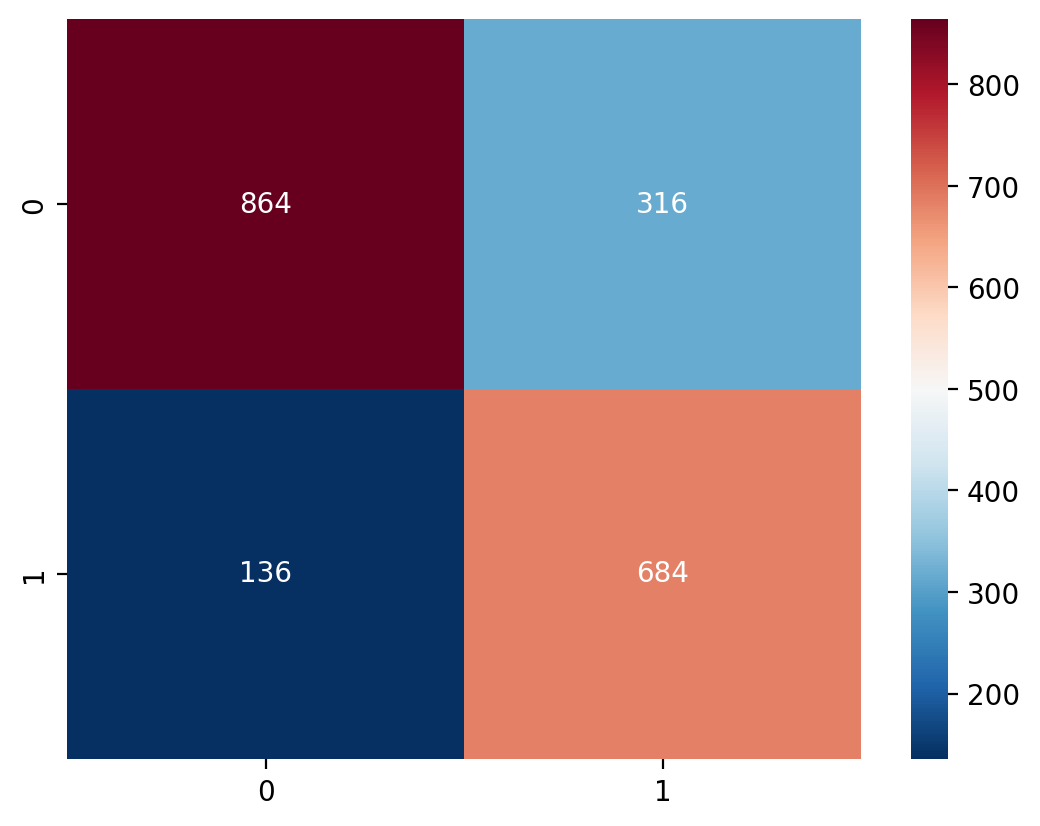

In [ ]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
TP, FP, FN, TN = test_model(model, dataloaders['test'], gpu=True)

cm_data = [[TP, FN], [FP, TN]]

sns.heatmap(cm_data, annot=True, cmap='RdBu_r', fmt='d')
plt.savefig("Confusion.pdf", format="pdf", bbox_inches="tight", dpi=300)

Our initial training results are not bad even after only 7 training epochs with 79.73% classification accuracy on the Test data set.

## Save the checkpoint

Once network is trained, we save the model and optimizer for continued training or making predictions.

In [ ]:
def save_checkpoint(filepath, epoch, model, optimizer, history):
    """Save PyTorch checkpoint on CPU with provided model, optimizer and training history

    Args:
        filepath (str): save file path
        epoch (int): training epoch being saved
        model: model for which checkpoint is being saved
        optimizer (torch.optim.Optimizer)
        history (dict(dict)): nested dictionary containing training and validation losses and accuracies

    Returns:
        None
    """

    print('Saving checkpoint...')

    model.to('cpu')

    checkpoint = {
        'arch': model.arch,
        'output_size': model.output_size,
        'class_to_idx': model.class_to_idx,
        'hidden_layers': model.hidden_layers,
        'drop_p': model.drop_p,
        'history': history,
        'epoch': best_epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict()
    }

    # Save checkpoint
    torch.save(checkpoint, filepath)

    file_size = os.path.getsize(filepath)
    print(f'Checkpoint saved: {(file_size / 1e9):.2f}Gb')

In [ ]:
save_checkpoint('checkpoint.pth', best_epoch, model, optimizer, history)

Saving checkpoint...
Checkpoint saved: 0.69Gb


In [ ]:
torch.load('checkpoint.pth')

## Loading the checkpoint

In [ ]:
def load_checkpoint(checkpoint_path, load_optimizer=False, gpu=False):
    """Load checkpoint and rebuild pretrained model.
       Optionally load and rebuild optimizer on device specified by gpu(bool)

    Args:
        checkpoint_path (str): checkpoint file path
        load_optmizer (bool): True: creates an optimizer and loads state_dict
                              False: does not create an optimizer
        gpu (bool): True attempt to load on GPU. If GPU is not available, user is notified

    Returns:
        model (): rebuilt pre-trained model
        optimizer (optim.Optimizer, None): optimizer  if load_optimizer==True, None otherwise
    """

    print('Loading model checkpoint...')

    # select device and check if gpu is available if requested
    device = select_device(gpu)

    # load checkpoint.
    # IMPORTANT Assumes checkpoint is saved on CPU
    if gpu:
        checkpoint = torch.load(checkpoint_path, map_location='cuda:0')
    else:
        checkpoint = torch.load(checkpoint_path, map_location='cpu')

    epoch = checkpoint['epoch']
    history = checkpoint['history']

    # Build model
    print('Re-building model...')
    model = create_model(arch=checkpoint['arch'],
                         output_size=checkpoint['output_size'],
                         class_to_idx=checkpoint['class_to_idx'],
                         hidden_layers=checkpoint['hidden_layers'],
                         drop_p=checkpoint['drop_p'])

    # Load model weights
    print('Loading state dictionary...')
    model.load_state_dict(checkpoint['model_state_dict'])
    model.to(device)

    # Create optimizer
    if load_optimizer:
        print('Loading optimizer...')
        optimizer = create_optimizer(model=model)
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    else:
        optimizer = None

    # Summarize training results
    print(f'Model checkpoint epoch {epoch} successfully loaded.')

    return model, optimizer, epoch, history

In [ ]:
# test load_checkpoint for training continuation (use GPU)
model, optimizer, epoch, history = load_checkpoint('checkpoint.pth', load_optimizer=True, gpu=True)
plot_history(history)

As seen from figure above, we still haven't fully saturated in validation accuracy after 9 training epochs and continue improving model performance since our last check after 7 training epochs. Out of curiosity, we can check if we perform better on unseen Test data (**IMPORTANT**: we cannot make any decisions about model training based on this Test data set result, since using test data more than once will bias our decision on the number of training epochs hyperparameter).

Note that our accuracy of classification on the Test data set improved from 79.73% to 82.3% with two additional training epochs. Again, we cannot use this result to make a decision when to stop training the model since Test data has now been "seen" by the training process more than once.

# Inference for classification

Now we write a function to use a trained network for inference.

## Image Preprocessing

- Use `PIL` module to load the image
- Resize crop out the center 224x224 portion of the image.
- Convert color channels from 0-255 to 0-1
- Normalize to
  - Mean `[0.485, 0.456, 0.406]`
  - Standard deviation`[0.229, 0.224, 0.225]`
- Reorder to put color channel as the first dimension (in `PIL` it is third)

In [ ]:
def process_image(image):
    """Scale, crop, and normalize a PIL image for a PyTorch model.

    Args:
        image (PIL image): raw input image

    Returns:
        image (numpy.array): transformed image
    """

    IMG_SIZE = 224  # Size of images used for training
    IMG_MEAN = [0.485, 0.456, 0.406]
    IMG_SDEV = [0.229, 0.224, 0.225]

    # Resize to 256 max dim
    if image.size[0] >= image.size[1]:
        image.thumbnail((256, image.size[1] * 256 // image.size[0]))
    else:
        image.thumbnail((image.size[0] * 256 // image.size[1], 256))

    # Center crop
    crop_box = ((image.size[0] - IMG_SIZE) // 2, (image.size[1] - IMG_SIZE) // 2,
                (image.size[0] + IMG_SIZE) // 2 , (image.size[1] + IMG_SIZE) // 2)
    image = image.crop(crop_box)

    # Convert to np.array and rescale color channels to 0-1
    image = np.array(image) / 255

    # Normalize image
    image = (image - np.array(IMG_MEAN)) / np.array(IMG_SDEV)

    # Rearrange to make color channel first dimension
    image = image.transpose(2, 0, 1)

    return image

In [ ]:
def imshow(image, ax=None, title=None):
    """Imshow for Tensor."""

    IMG_SIZE = 224  # Size of images used for training
    IMG_MEAN = [0.485, 0.456, 0.406]
    IMG_SDEV = [0.229, 0.224, 0.225]

    if ax is None:
        fig, ax = plt.subplots()

    # PyTorch tensors assume the color channel is the first dimension
    # but matplotlib assumes is the third dimension
    image = image.transpose((1, 2, 0))

    # Undo preprocessing
    image = np.array(IMG_SDEV) * image + np.array(IMG_MEAN)

    # Image needs to be clipped between 0 and 1 or it looks like noise when displayed
    image = np.clip(image, 0, 1)

    ax.imshow(image)

    return ax

Processed image shape (3, 224, 224)


<Axes: >

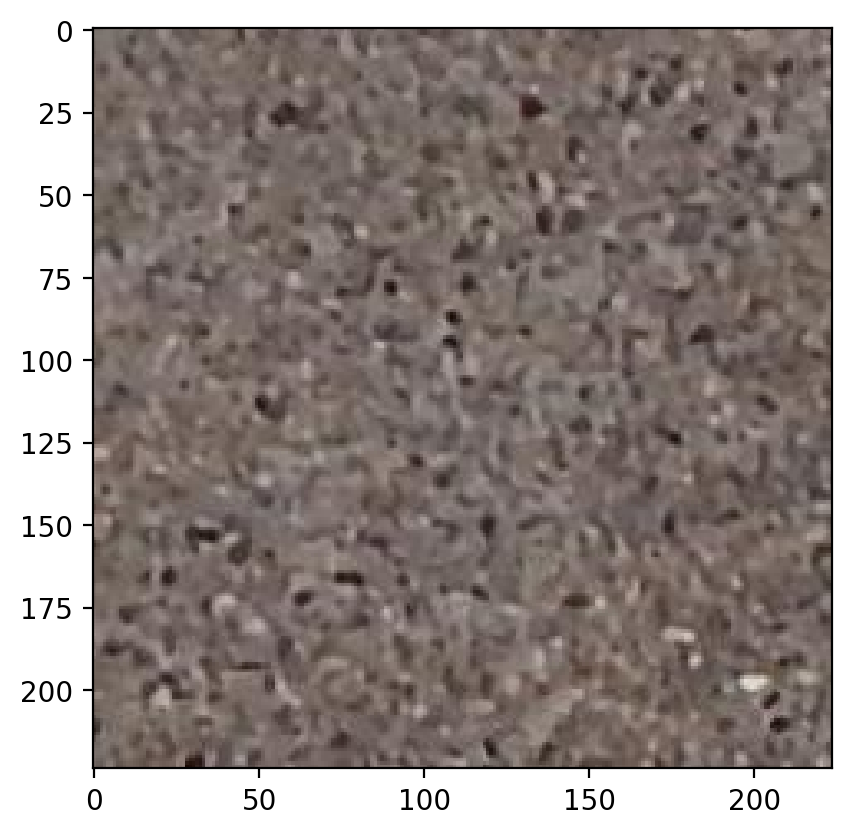

In [ ]:
img = Image.open('/content/Twoclass/test/2/001-79.jpg')
processed_img = process_image(img)
print(f'Processed image shape {processed_img.shape}')
imshow(processed_img)


## Class Prediction

Return top-k predicted class probabilities and label image with the highest probability class.

In [ ]:
def predict(img_path, checkpoint_path, topk=2, gpu=False):
    """Predict the class (or classes) of an image using a trained deep learning model.

    Args:
        img_path (str): path to image for classfication
        checkpoint_path (str): path to PyTorch model checkpoint
        topk (int): number of top predicitions to return

    Returns:
        probs ([float]): list of predicition probabilities
        classes ([str]): list of predicted class indices
        class_names ([str]): list of predicted class names
    """

    # Select device
    device = select_device(gpu)

    # Load and process image
    img = process_image(Image.open(img_path))

    # Convert image from numpy to torch
    img_tensor = torch.from_numpy(np.expand_dims(img, axis=0)).type(torch.FloatTensor)

    # load model
    # model moved to device specified by gpu(bool) on load
    model, _, _, _ = load_checkpoint(checkpoint_path, load_optimizer=False, gpu=gpu)

    # image to device.

    img_tensor = img_tensor.to(device)

    # Classify image
    model.eval()
    with torch.no_grad():
        output = torch.exp(model(img_tensor))

    # Get topk probabilities and class indices
    probs, preds = output.topk(topk, dim=1)
    probs, preds = probs.tolist()[0], preds.tolist()[0]

    # convert indeces to named classes using model.class_to_idx and cat_to_name
    class_dict = {val: key for key, val in model.class_to_idx.items()}
    classes = [class_dict[x] for x in preds]
    class_names = [cat_to_name[x] for x in classes]

    return probs, classes, class_names



In [ ]:
probs, classes, class_names = predict('/content/Twoclass/test/2/001-79.jpg', 'checkpoint.pth', topk=2, gpu=True)
print(probs)
print(classes)
print(class_names)

Loading model checkpoint...
Re-building model...


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading state dictionary...
Model checkpoint epoch 3 successfully loaded.
[0.6335214972496033, 0.3664785325527191]
['2', '1']
['Non-Crack', 'Crack']


In [ ]:
def display_classification(img_path, checkpoint_path, topk=2):
    """Display model prediction.

    Args:
        img_path (str): path to image to be classified
        checkpoint_path (str): path to pre-trained classifier model file
        top-k (int): number of top class probabilities to display

    Returns:
        None
    """
    # Get model predictions
    probs, classes, class_names = predict(img_path, checkpoint_path, topk=topk, gpu=False)

    # Setup plot gird and title
    fig = plt.figure(figsize=(4, 5.4))
    ax1 = plt.subplot2grid((2, 1), (0, 0))
    ax2 = plt.subplot2grid((2, 1), (1, 0))
    fig.suptitle(class_names[0].capitalize(), x=0.6, y=1, fontsize=16)

    # Display image
    ax1.imshow(Image.open(img_path))
    ax1.set_xticks([])
    ax1.set_yticks([])

    # Display predicted classes and probabilities
    y = np.arange(len(class_names))  # setup y axis grid
    ax2.barh(y, probs)
    ax2.set_yticks(y)
    ax2.set_yticklabels(class_names)
    ax2.invert_yaxis()  # prediction with highest probability on top
    ax2.set_xlabel('Prediction probability')

    # Adjust layout
    fig.tight_layout()

Loading model checkpoint...
Re-building model...
Loading state dictionary...
Model checkpoint epoch 3 successfully loaded.


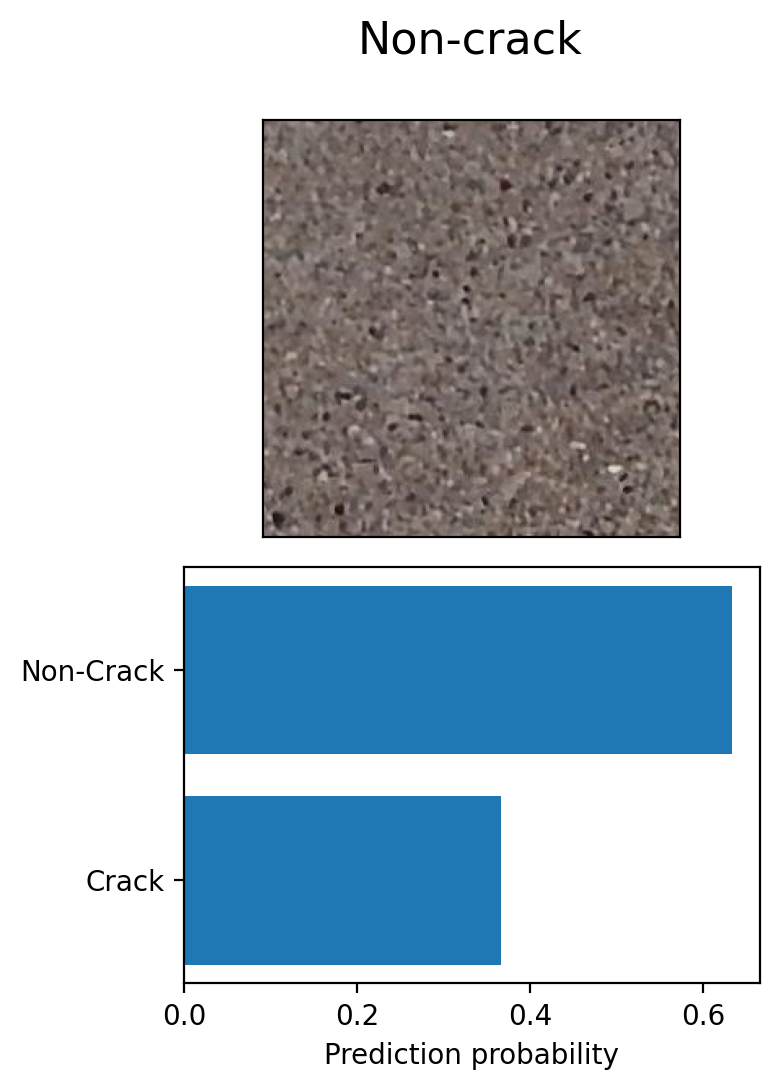

In [ ]:
display_classification('/content/Twoclass/test/2/001-79.jpg', 'checkpoint.pth', topk=2)